# CNN & Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such visual data can be images, videos, or even live streams. In this notebook, we'll explore how to use convolutional neural networks to perform computer vision tasks.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import cv2
import pathlib
import random
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam


## Get the Data

The images we are working with are from the [Food101](https://www.kaggle.com/datasets/dansbecker/food-101) dataset (101 different classes of food). However, we're going to simplify things and only use two classes:
1. Pizza
2. Steak

In [5]:
# Download zip file of pizza_steak images
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
#zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
#zip_ref.extractall()
#zip_ref.close()

## Inspect the data

In [6]:
!ls pizza_steak

test  train


In [7]:
!ls pizza_steak/train/steak

1000205.jpg 1647351.jpg 2238681.jpg 2824680.jpg 3375959.jpg 417368.jpg
100135.jpg  1650002.jpg 2238802.jpg 2825100.jpg 3381560.jpg 4176.jpg
101312.jpg  165639.jpg  2254705.jpg 2826987.jpg 3382936.jpg 42125.jpg
1021458.jpg 1658186.jpg 225990.jpg  2832499.jpg 3386119.jpg 421476.jpg
1032846.jpg 1658443.jpg 2260231.jpg 2832960.jpg 3388717.jpg 421561.jpg
10380.jpg   165964.jpg  2268692.jpg 285045.jpg  3389138.jpg 438871.jpg
1049459.jpg 167069.jpg  2271133.jpg 285147.jpg  3393547.jpg 43924.jpg
1053665.jpg 1675632.jpg 227576.jpg  2855315.jpg 3393688.jpg 440188.jpg
1068516.jpg 1678108.jpg 2283057.jpg 2856066.jpg 3396589.jpg 442757.jpg
1068975.jpg 168006.jpg  2286639.jpg 2859933.jpg 339891.jpg  443210.jpg
1081258.jpg 1682496.jpg 2287136.jpg 286219.jpg  3417789.jpg 444064.jpg
1090122.jpg 1684438.jpg 2291292.jpg 2862562.jpg 3425047.jpg 444709.jpg
1093966.jpg 168775.jpg  229323.jpg  2865730.jpg 3434983.jpg 447557.jpg
1098844.jpg 1697339.jpg 2300534.jpg 2878151.jpg 3435358.jpg 461187.jpg
1100074.jp

In [8]:
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak/test
There are 0 directories and 250 images in pizza_steak/test/steak
There are 0 directories and 250 images in pizza_steak/test/pizza
There are 2 directories and 0 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/steak
There are 0 directories and 750 images in pizza_steak/train/pizza


In [9]:
len(os.listdir("pizza_steak/train/pizza"))

750

In [10]:
len(os.listdir("pizza_steak/train/steak"))

750

In [11]:
# Get the classnames programatically
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


In [12]:
# Visualize the data
def view_random_image(target_dir, target_class):
    # Setup the target directory 
    target_folder = target_dir+target_class
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    plt.show()
    
    print(f"Image shape: {img.shape}")
    return img

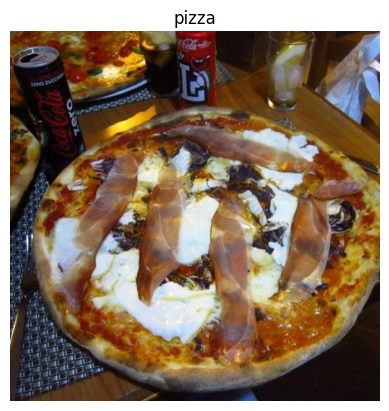

Image shape: (512, 512, 3)


In [13]:
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="pizza")

In [14]:
img

array([[[ 56,  78, 128],
        [ 60,  80, 130],
        [ 62,  81, 124],
        ...,
        [ 70,  50,  41],
        [ 63,  42,  37],
        [ 69,  50,  46]],

       [[ 51,  66, 105],
        [ 56,  70, 107],
        [ 60,  73, 105],
        ...,
        [ 78,  60,  56],
        [ 80,  64,  64],
        [ 75,  59,  60]],

       [[ 56,  60,  72],
        [ 61,  63,  75],
        [ 67,  67,  75],
        ...,
        [116, 105, 111],
        [127, 117, 128],
        [100,  92, 105]],

       ...,

       [[ 46,  38,  36],
        [ 41,  33,  31],
        [ 42,  36,  36],
        ...,
        [ 19,  11,   9],
        [ 19,  11,   9],
        [ 20,  12,  10]],

       [[ 42,  37,  33],
        [ 40,  35,  31],
        [ 41,  36,  33],
        ...,
        [ 19,  10,  11],
        [ 19,  10,  11],
        [ 19,  10,  11]],

       [[ 41,  36,  32],
        [ 42,  37,  33],
        [ 40,  35,  32],
        ...,
        [ 22,  13,  14],
        [ 23,  14,  15],
        [ 23,  14,  15]]

In [15]:
img.shape

(512, 512, 3)

**Note**: Many `ML` models, including `Neural Networks` prefer the values to be between 0 & 1. This is called `Normalization`. We can normalize the image by dividing each pixel value by 255. We can do this by defining a `Normalization` layer in the `CNN` model.

In [16]:
img/255.

array([[[0.21960784, 0.30588235, 0.50196078],
        [0.23529412, 0.31372549, 0.50980392],
        [0.24313725, 0.31764706, 0.48627451],
        ...,
        [0.2745098 , 0.19607843, 0.16078431],
        [0.24705882, 0.16470588, 0.14509804],
        [0.27058824, 0.19607843, 0.18039216]],

       [[0.2       , 0.25882353, 0.41176471],
        [0.21960784, 0.2745098 , 0.41960784],
        [0.23529412, 0.28627451, 0.41176471],
        ...,
        [0.30588235, 0.23529412, 0.21960784],
        [0.31372549, 0.25098039, 0.25098039],
        [0.29411765, 0.23137255, 0.23529412]],

       [[0.21960784, 0.23529412, 0.28235294],
        [0.23921569, 0.24705882, 0.29411765],
        [0.2627451 , 0.2627451 , 0.29411765],
        ...,
        [0.45490196, 0.41176471, 0.43529412],
        [0.49803922, 0.45882353, 0.50196078],
        [0.39215686, 0.36078431, 0.41176471]],

       ...,

       [[0.18039216, 0.14901961, 0.14117647],
        [0.16078431, 0.12941176, 0.12156863],
        [0.16470588, 0

## An end-to-end example of a CNN for computer vision

* Load the images
* Preprocess the images
* Build a CNN model
* Compile the model
* Fit the model
* Evaluate the model

In [17]:
tf.random.set_seed(42)

# Preprocess the data (get all of the pixel values between 0 and 1, as normalizing/standardizing/scaling does)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

#Import data and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time (default=32)
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed = 42
)
valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed = 42
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [18]:
# Build a CNN model 
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3, # can also be (3, 3)
                           activation="relu",
                           input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                              padding="valid"), # padding can also be "same"
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output for binary classification
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data, 
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data)
                        )

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Epoch 1/10


2023-08-04 12:15:41.415002: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


47/47 [==============================] - 6s 110ms/step - loss: 0.5674 - accuracy: 0.7220 - val_loss: 0.4784 - val_accuracy: 0.7500
Epoch 2/10
47/47 [==============================] - 5s 101ms/step - loss: 0.4418 - accuracy: 0.8047 - val_loss: 0.3442 - val_accuracy: 0.8520
Epoch 3/10
47/47 [==============================] - 5s 101ms/step - loss: 0.3812 - accuracy: 0.8407 - val_loss: 0.3226 - val_accuracy: 0.8580
Epoch 4/10
47/47 [==============================] - 5s 98ms/step - loss: 0.3398 - accuracy: 0.8607 - val_loss: 0.3103 - val_accuracy: 0.8520
Epoch 5/10
47/47 [==============================] - 5s 100ms/step - loss: 0.2678 - accuracy: 0.8913 - val_loss: 0.4267 - val_accuracy: 0.8000
Epoch 6/10
47/47 [==============================] - 5s 97ms/step - loss: 0.2615 - accuracy: 0.8980 - val_loss: 0.3585 - val_accuracy: 0.8420
Epoch 7/10
47/47 [==============================] - 4s 93ms/step - loss: 0.1862 - accuracy: 0.9347 - val_loss: 0.4069 - val_accuracy: 0.8300
Epoch 8/10
47/47 [==

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

## Binary Classification: Breaking it down

1. Check the data
2. Preprocess the data (prepare it for the model, scaling/normalization)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different hyperparameters to improve the model
7. Repeat until satisfied

### 1. Check out the data

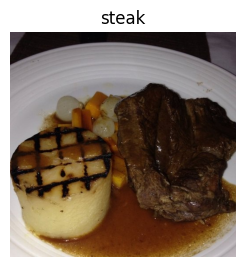

Image shape: (512, 512, 3)


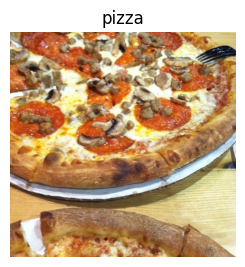

Image shape: (512, 512, 3)


In [22]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1,2,2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")


### Preprocess the data

In [24]:
# Define directory dataset path
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Create train and test data generators and rescale the data
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Turn data into batches(A batch is a small subset of data, rather than looking at the entire dataset at once, the model only looks at 
# one batch(32 in this case) at a time)
train_data = train_datagen.flow_from_directory(directory=train_dir, # target directory
                                               target_size=(224, 224), # target size
                                               class_mode="binary", # type of problem
                                               batch_size=32 # size of batches
)
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [25]:
images, labels = train_data.next() # get the next batch of images/labels
len(images), len(labels)

(32, 32)

In [27]:
# Get the first 2 images
images[:2], images[0].shape

(array([[[[0.7254902 , 0.69411767, 0.6431373 ],
          [0.70980394, 0.6784314 , 0.627451  ],
          [0.6       , 0.5686275 , 0.5176471 ],
          ...,
          [0.22352943, 0.12156864, 0.07058824],
          [0.1764706 , 0.10196079, 0.07450981],
          [0.14117648, 0.08627451, 0.07450981]],
 
         [[0.7254902 , 0.69411767, 0.6431373 ],
          [0.69411767, 0.6627451 , 0.6117647 ],
          [0.5921569 , 0.56078434, 0.5176471 ],
          ...,
          [0.18823531, 0.09803922, 0.04313726],
          [0.17254902, 0.09803922, 0.07058824],
          [0.15294118, 0.09411766, 0.07450981]],
 
         [[0.7294118 , 0.69803923, 0.654902  ],
          [0.7058824 , 0.6745098 , 0.6313726 ],
          [0.6627451 , 0.6313726 , 0.5882353 ],
          ...,
          [0.16862746, 0.08235294, 0.03921569],
          [0.1764706 , 0.10196079, 0.07450981],
          [0.16078432, 0.09411766, 0.06666667]],
 
         ...,
 
         [[0.21568629, 0.10980393, 0.07450981],
          [0.20000

### 3. Build the Model

> **Note:** In deep learning, there is almost an infinite amount of architectures one could create. So one of the best ways to get started is to start with something simple and see if it works on the data. Then introduce complexity as needed.

In [29]:
# Starting with a baseline CNN model(A baseline model is a simple model that you compare your model's performance to)
model_2 = Sequential([
    Conv2D(filters=10, # the no of sliding windows going across an input(higher = more patterns learned)
           kernel_size=3, # size of the sliding window that moves across the image
           strides=1, # how much the sliding window moves across the image by
           padding='valid', # padding='same' means output shape is same as input shape, padding='valid' means output shape is smaller than input shape
           activation='relu', 
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [30]:
# Compile the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# Summary of the model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 4. Fit the model

In [32]:
history_2 = model_2.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data)
                        )

Epoch 1/10
47/47 [==============================] - 21s 375ms/step - loss: 0.8821 - accuracy: 0.6433 - val_loss: 0.3759 - val_accuracy: 0.8380
Epoch 2/10
47/47 [==============================] - 14s 307ms/step - loss: 0.4004 - accuracy: 0.8273 - val_loss: 0.3491 - val_accuracy: 0.8520
Epoch 3/10
47/47 [==============================] - 12s 259ms/step - loss: 0.3061 - accuracy: 0.8780 - val_loss: 0.3606 - val_accuracy: 0.8500
Epoch 4/10
47/47 [==============================] - 14s 289ms/step - loss: 0.1974 - accuracy: 0.9353 - val_loss: 0.3870 - val_accuracy: 0.8180
Epoch 5/10
47/47 [==============================] - 15s 318ms/step - loss: 0.0711 - accuracy: 0.9893 - val_loss: 0.4427 - val_accuracy: 0.8320
Epoch 6/10
47/47 [==============================] - 23s 499ms/step - loss: 0.0218 - accuracy: 0.9993 - val_loss: 0.3961 - val_accuracy: 0.8560
Epoch 7/10
47/47 [==============================] - 12s 251ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.4488 - val_accuracy: 0.8520

### 5. Evaluating the Model

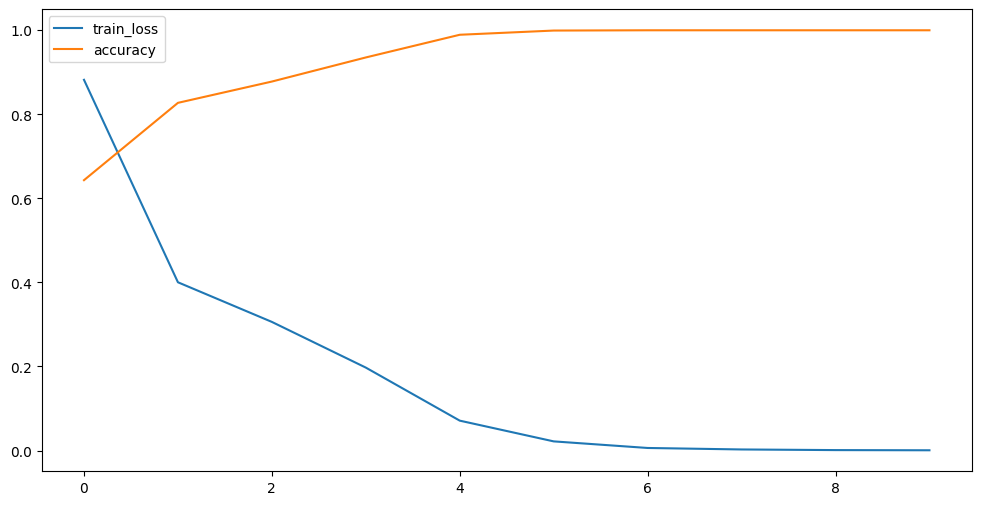

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'], label='train_loss')
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

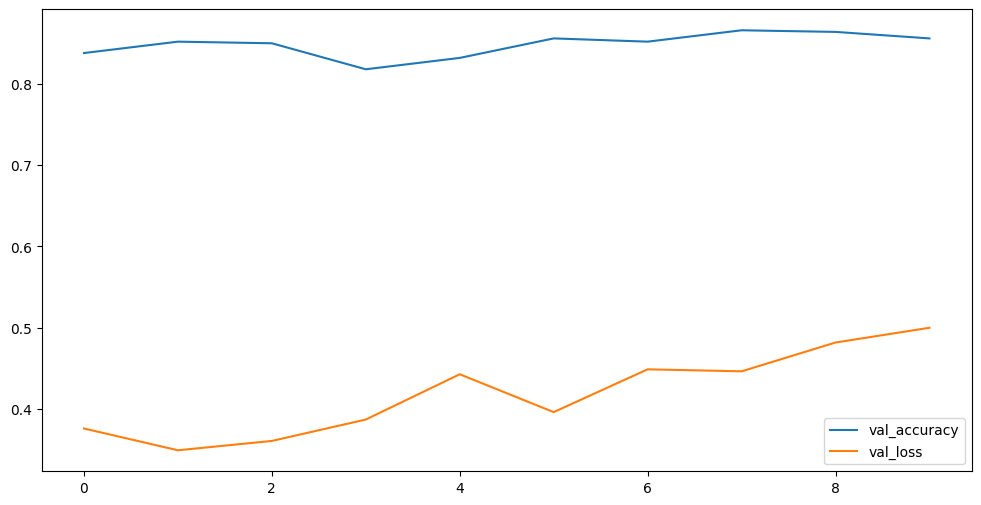

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['val_accuracy'], label='val_accuracy')
plt.plot(history_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()